In [1]:
import pandas as pd
import time
from ortools.linear_solver import pywraplp
from utils import save_plot
import matplotlib.pyplot as plt
DATA_PATH = "../data/dairy_cows.csv"  # or wherever your data is located

df = pd.read_csv(DATA_PATH)
df.head()

,ID,Species,Animal_Class,WQ_Principles,WQ_Criteria,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Affective_States,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,Welfare_Indicator,Indicator_Type,Indicator_Dimensions,Indicator_Ease,Indicator_Resources,Hazards_Source_1,Hazards_Source_2,Global_Usage,Norway_Usage
0,1,Dairy cows,Tie stalls,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,Abdominal discomfort,Welfare outcome,Health/physical/production,Moderate,Low,7.0,NaN,F,Y
1,1,Dairy cows,Cubicles,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,Abdominal discomfort,Welfare outcome,Health/physical/production,Moderate,Low,7.0,NaN,F,Y
2,2,Dairy cows,Tie stalls,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,Agonistic behaviour,Welfare outcome,Behavioural,Moderate,Low,7.0,NaN,"F, R",Y
3,2,Dairy cows,Cubicles,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,Agonistic behaviour,Welfare outcome,Behavioural,Moderate,Low,7.0,NaN,"F, R",Y
4,3,Dairy cows,Tie stalls,Appropiate behaviour,Expression of other behaviours,Insufficient space,Restriction of movement,Discomfort,High,Moderate,Agonistic interactions,Welfare outcome,Behavioural,Moderate,Medium,NaN,13a,R,N (research only)


In [2]:
def normalize_column(col):
    return (col - col.min()) / (col.max() - col.min())

# Define Numerical Mappings
ease_mapping = {'Easy': 1, 'Moderate': 2, 'Difficult': 3}
impact_mapping = {'Low': 1, 'High': 2}
mitigation_mapping = {'Easy': 1, 'Moderate': 2, 'Difficult': 3}

# Mapping dictionaries
ease_mapping = {'Easy': 1, 'Moderate': 2, 'Difficult': 3}
impact_mapping = {'Low': 1, 'High': 2}
resources_mapping = {'Low': 1, 'Medium': 2, 'High': 3}

# Create numeric columns
df['Ease_Num'] = df['Indicator_Ease'].map(ease_mapping)
df['Impact_Num'] = df['Welfare_Hazards_Impact'].map(impact_mapping)
df['Mitigation_Ease_Num'] = df['Ease_of_Hazard_Mitigation'].map(ease_mapping)
df['Resources_Num'] = df['Indicator_Resources'].map(resources_mapping)


In [3]:
# Coverage calculation
coverage_df = df.groupby('Welfare_Indicator').agg({
    'Welfare_Hazards_Animal': pd.Series.nunique,
    'Welfare_Hazards_Consequences': pd.Series.nunique,
    'Ease_Num': 'mean',
    'Impact_Num': 'mean',
    'Mitigation_Ease_Num': 'mean'
}).rename(columns={
    'Welfare_Hazards_Animal': 'riskCoverage',
    'Welfare_Hazards_Consequences': 'consequenceCoverage'
}).reset_index()


In [4]:
coverage_df.head()

,Welfare_Indicator,riskCoverage,consequenceCoverage,Ease_Num,Impact_Num,Mitigation_Ease_Num
0,Abdominal discomfort,1,1,2.0,2.0,2.0
1,Agonistic behaviour,1,1,2.0,1.0,3.0
2,Agonistic interactions,1,1,2.0,2.0,2.0
3,Allo-grooming,1,1,2.0,1.0,3.0
4,Altered resting posture,1,1,2.0,2.0,3.0


Apply Min-Max normalization:

\text{Normalized Factor} = \frac{x_i - x_{\min}}{x_{\max} - x_{\min}}

For indicators where lower numeric values are better (e.g., easiness, mitigation ease), invert the normalization:

- For example, easiness normalization (lower number is easier and better):

\[
\text{Normalized Easiness}_i = \frac{x_{\max} - x_i}{x_{\max} - x_{\min}}
\]


In [5]:
coverage_df

,Welfare_Indicator,riskCoverage,consequenceCoverage,Ease_Num,Impact_Num,Mitigation_Ease_Num
0,Abdominal discomfort,1,1,2.0,2.000000,2.000000
1,Agonistic behaviour,1,1,2.0,1.000000,3.000000
2,Agonistic interactions,1,1,2.0,2.000000,2.000000
3,Allo-grooming,1,1,2.0,1.000000,3.000000
4,Altered resting posture,1,1,2.0,2.000000,3.000000
5,Amount of eye white,2,1,2.0,2.000000,2.000000
6,Body condition scoring,4,1,2.0,2.000000,1.500000
7,Brush use,1,1,2.0,1.000000,3.000000
8,Calving behaviour (difficult/long calving),1,1,2.0,2.000000,2.000000
9,Calving records (death of cow),3,1,1.0,2.000000,1.333333


## Normalize

In [6]:
# Define Numerical Mappings
ease_mapping = {'Easy': 1, 'Moderate': 2, 'Difficult': 3}
impact_mapping = {'Low': 1, 'High': 2}
mitigation_mapping = {'Easy': 1, 'Moderate': 2, 'Difficult': 3}

# Mapping dictionaries
ease_mapping = {'Easy': 1, 'Moderate': 2, 'Difficult': 3}
impact_mapping = {'Low': 1, 'High': 2}
resources_mapping = {'Low': 1, 'Medium': 2, 'High': 3}

# Create numeric columns
df['Ease_Num'] = df['Indicator_Ease'].map(ease_mapping)
df['Impact_Num'] = df['Welfare_Hazards_Impact'].map(impact_mapping)
df['Mitigation_Ease_Num'] = df['Ease_of_Hazard_Mitigation'].map(ease_mapping)
df['Resources_Num'] = df['Indicator_Resources'].map(resources_mapping)

# Coverage calculation
coverage_df = df.groupby('Welfare_Indicator').agg({
    'Welfare_Hazards_Animal': pd.Series.nunique,
    'Welfare_Hazards_Consequences': pd.Series.nunique,
    'Ease_Num': 'mean',
    'Impact_Num': 'mean',
    'Mitigation_Ease_Num': 'mean'
}).rename(columns={
    'Welfare_Hazards_Animal': 'riskCoverage',
    'Welfare_Hazards_Consequences': 'consequenceCoverage'
}).reset_index()

# Normalize coverage factors (higher is better)
coverage_df['norm_riskCoverage'] = (
    (coverage_df['riskCoverage'] - coverage_df['riskCoverage'].min()) / 
    (coverage_df['riskCoverage'].max() - coverage_df['riskCoverage'].min())
)

coverage_df['norm_consequenceCoverage'] = (
    (coverage_df['consequenceCoverage'] - coverage_df['consequenceCoverage'].min()) / 
    (coverage_df['consequenceCoverage'].max() - coverage_df['consequenceCoverage'].min())
)

# Normalize easiness (lower numeric is easier, thus better)
coverage_df['norm_easiness'] = (
    (coverage_df['Ease_Num'].max() - coverage_df['Ease_Num']) /
    (coverage_df['Ease_Num'].max() - coverage_df['Ease_Num'].min())
)

# Normalize impact (higher numeric is better)
coverage_df['norm_impact'] = (
    (coverage_df['Impact_Num'] - coverage_df['Impact_Num'].min()) /
    (coverage_df['Impact_Num'].max() - coverage_df['Impact_Num'].min())
)

# Normalize mitigation ease (lower numeric easier, better)
coverage_df['norm_mitigation'] = (
    (coverage_df['Mitigation_Ease_Num'].max() - coverage_df['Mitigation_Ease_Num']) /
    (coverage_df['Mitigation_Ease_Num'].max() - coverage_df['Mitigation_Ease_Num'].min())
)

In [7]:

def run_optimization(num_indicators=10, weight_cover=1.0, weight_ease=1.0, weight_impact=1.0, weight_mitigation=1.0):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        return None

    indicators = coverage_df['Welfare_Indicator'].unique()
    x = {i: solver.BoolVar(f'x_{i}') for i in indicators}

    # Objective Function
    objective = solver.Objective()
    for i in indicators:
        row = coverage_df[coverage_df['Welfare_Indicator'] == i]

        coverage_score = weight_cover * (0.5 * row['norm_riskCoverage'].values[0] + 
                                         0.5 * row['norm_consequenceCoverage'].values[0])
        ease_score = weight_ease * row['norm_easiness'].values[0]
        impact_score = weight_impact * row['norm_impact'].values[0]
        mitigation_score = weight_mitigation * row['norm_mitigation'].values[0]

        obj_value = coverage_score + ease_score + impact_score + mitigation_score
        objective.SetCoefficient(x[i], obj_value)

    objective.SetMaximization()

    # Constraint: Select only `num_indicators`
    solver.Add(solver.Sum(x[i] for i in indicators) <= num_indicators)

    solver.Solve()

    selected_indicators = [i for i in indicators if x[i].solution_value() > 0.5]
    return {
        'objective': solver.Objective().Value(),
        'selected_indicators': selected_indicators
    }

run_optimization()

{'objective': 25.65740740740741,
 'selected_indicators': ['Calving records (death of cow)',
  'Calving records (difficulty calving)',
  'Calving records (duration of calving)',
  'Coat condiition / cleanliness',
  'Distended udder',
  'Neck injuries',
  'Reproductive disorders',
  'Sunburn injury',
  'Teat disorders',
  'Weight loss (adults) or restricted weight gain (calves)']}

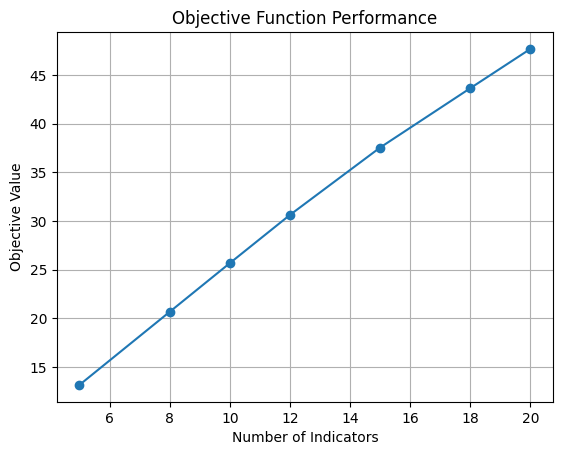

In [11]:
def track_objective_performance():
    scenarios = [5, 8, 10, 12, 15, 18, 20]
    results = []
    
    for scenario in scenarios:
        solution = run_optimization(num_indicators=scenario)
        results.append({'scenario': scenario, 'objective': solution['objective']})
    
    df_results = pd.DataFrame(results)

    # Visualization
    plt.plot(df_results['scenario'], df_results['objective'], marker='o')
    plt.xlabel('Number of Indicators')
    plt.ylabel('Objective Value')
    plt.title('Objective Function Performance')
    plt.grid()
    #plt.show()
    save_plot(plt.gcf(), "objective_performance")
    return df_results

df_performance = track_objective_performance()


### Sensitivity Analysis

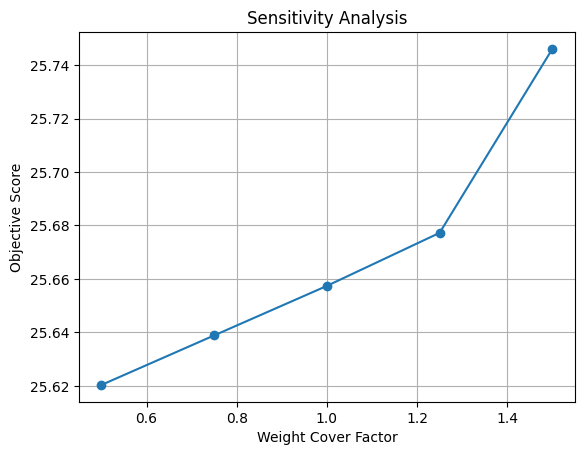

In [12]:
import numpy as  np
def sensitivity_analysis():
    param_variations = np.linspace(0.5, 1.5, 5)
    results = []

    for weight_cover in param_variations:
        solution = run_optimization(weight_cover=weight_cover)
        results.append({'weight_cover': weight_cover, 'objective': solution['objective']})

    df_sensitivity = pd.DataFrame(results)

    # Visualization
    plt.plot(df_sensitivity['weight_cover'], df_sensitivity['objective'], marker='o')
    plt.xlabel('Weight Cover Factor')
    plt.ylabel('Objective Score')
    plt.title('Sensitivity Analysis')
    plt.grid()
    #plt.show()
    save_plot(plt.gcf(), "sensitivity_analysis")
    return df_sensitivity

df_sensitivity = sensitivity_analysis()



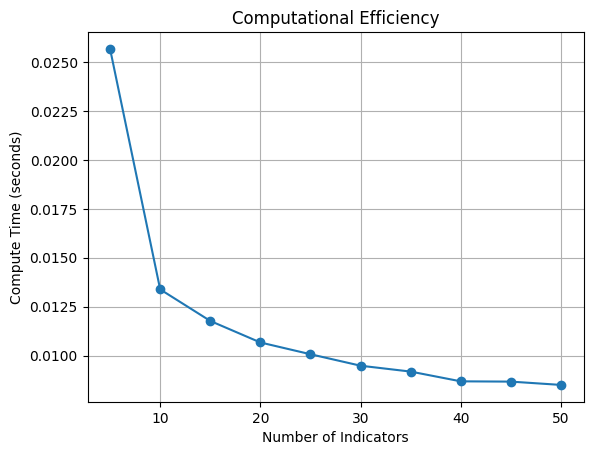

In [13]:
def computational_efficiency():
    indicators_range = range(5, 51, 5)
    timings = []

    for n in indicators_range:
        start_time = time.time()
        run_optimization(num_indicators=n)
        end_time = time.time()
        timings.append({'indicators': n, 'compute_time_sec': end_time - start_time})

    df_efficiency = pd.DataFrame(timings)

    # Visualization
    plt.plot(df_efficiency['indicators'], df_efficiency['compute_time_sec'], marker='o')
    plt.xlabel('Number of Indicators')
    plt.ylabel('Compute Time (seconds)')
    plt.title('Computational Efficiency')
    plt.grid()
    #plt.show()
    save_plot(plt.gcf(),"sensitivity_analysis")

    return df_efficiency

df_efficiency = computational_efficiency()



Scenario: Best Case
Selected Indicators: Calving records (death of cow), Calving records (difficulty calving), Calving records (duration of calving), Coat condiition / cleanliness, Distended udder, Injuries, Reproductive disorders, Sunburn injury, Teat disorders, Weight loss (adults) or restricted weight gain (calves)

Scenario: Worst Case
Selected Indicators: Calving records (death of cow), Calving records (difficulty calving), Calving records (duration of calving), Coat condiition / cleanliness, Distended udder, Neck injuries, Reproductive disorders, Sunburn injury, Teat disorders, Weight loss (adults) or restricted weight gain (calves)

Scenario: Cost-Effective
Selected Indicators: Calving records (death of cow), Calving records (difficulty calving), Calving records (duration of calving), Coat condiition / cleanliness, Distended udder, Injuries, Reproductive disorders, Sunburn injury, Teat disorders, Weight loss (adults) or restricted weight gain (calves)

Scenario: High-Risk Prior

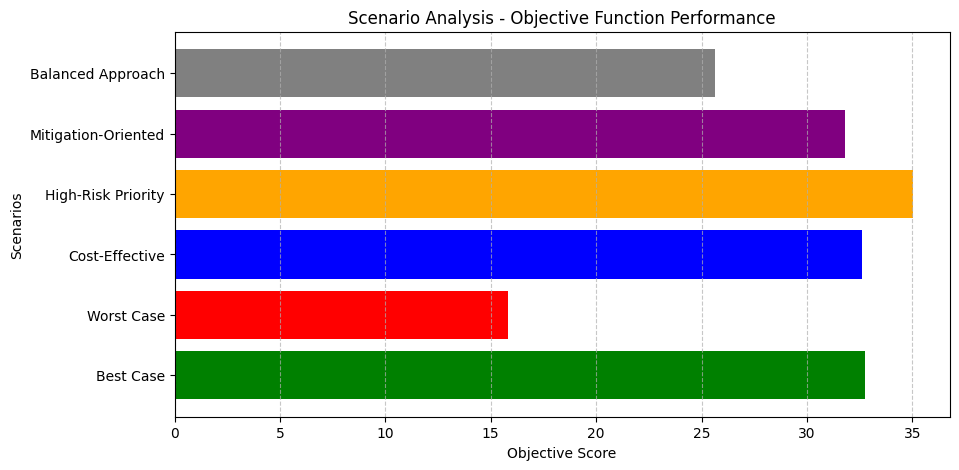

In [14]:
def advanced_scenario_analysis():
    """
    Defines and analyzes various realistic scenarios, applying the optimization function
    under different assumptions.
    """

    scenarios = {
        'Best Case': {
            'weight_cover': 1.5,  # Emphasizing coverage
            'weight_ease': 1.5,   # Favoring easily measurable indicators
            'weight_impact': 1.2,  # Preferring high-impact indicators
            'weight_mitigation': 1.0  # Moderate emphasis on mitigation difficulty
        },
        'Worst Case': {
            'weight_cover': 0.5,  
            'weight_ease': 0.5,   
            'weight_impact': 0.8,  
            'weight_mitigation': 0.5  # Low preference for mitigation
        },
        'Cost-Effective': {
            'weight_cover': 1.2,  
            'weight_ease': 1.8,   # Strongly prioritizing ease of measurement
            'weight_impact': 1.0,  
            'weight_mitigation': 0.8  # Some focus on mitigation, but not primary
        },
        'High-Risk Priority': {
            'weight_cover': 1.5,  
            'weight_ease': 0.8,   # Less concern about ease, more on coverage
            'weight_impact': 2.0,  # Maximizing impact
            'weight_mitigation': 1.2  
        },
        'Mitigation-Oriented': {
            'weight_cover': 1.0,  
            'weight_ease': 1.0,   
            'weight_impact': 1.0,  
            'weight_mitigation': 2.0  # Strongly favoring easily mitigable hazards
        },
        'Balanced Approach': {
            'weight_cover': 1.0,  
            'weight_ease': 1.0,   
            'weight_impact': 1.0,  
            'weight_mitigation': 1.0  # Neutral weighting across all factors
        }
    }

    results = []

    for scenario_name, params in scenarios.items():
        solution = run_optimization(
            num_indicators=10,
            weight_cover=params['weight_cover'],
            weight_ease=params['weight_ease'],
            weight_impact=params['weight_impact'],
            weight_mitigation=params['weight_mitigation']
        )
        results.append({
            'scenario': scenario_name,
            'objective': solution['objective'],
            'selected_indicators': solution['selected_indicators']
        })

    df_scenarios = pd.DataFrame(results)

    # Visualization - Scenario Objective Values
    plt.figure(figsize=(10, 5))
    plt.barh(df_scenarios['scenario'], df_scenarios['objective'], color=['green', 'red', 'blue', 'orange', 'purple', 'gray'])
    plt.title('Scenario Analysis - Objective Function Performance')
    plt.xlabel('Objective Score')
    plt.ylabel('Scenarios')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    #plt.show()
    save_plot(plt.gcf(),"scenario_analysis")

    # Display selected indicators per scenario
    for _, row in df_scenarios.iterrows():
        print(f"\nScenario: {row['scenario']}")
        print(f"Selected Indicators: {', '.join(row['selected_indicators'])}")

    return df_scenarios

df_scenarios = advanced_scenario_analysis()



### Stability analysis

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Initialize results storage
stability_results = []

# Parameters to test
parameters_to_test = ['weight_cover', 'weight_ease', 'weight_impact', 'weight_mitigation']

# Variations (-50%, Baseline, +50%)
variations = [ -0.5, 0, 0.5]

for param in parameters_to_test:
    for variation in variations:
        # Modify parameter values
        params = {
            'weight_cover': 1.0,
            'weight_ease': 1.0,
            'weight_impact': 1.0,
            'weight_mitigation': 1.0
        }
        params[param] *= (1 + variation)

        # Run optimization for the modified parameters
        optimal_solution = run_optimization(
            num_indicators=10, 
            weight_cover=params['weight_cover'],
            weight_ease=params['weight_ease'],
            weight_impact=params['weight_impact'],
            weight_mitigation=params['weight_mitigation']
        )

        # Store results
        stability_results.append({
            'Parameter': param,
            'Variation (%)': variation * 100,
            'Selected Indicators': optimal_solution['selected_indicators']
        })

# Convert results into a DataFrame
stability_df = pd.DataFrame(stability_results)

# Print formatted results
for param in stability_df['Parameter'].unique():
    print(f"\nStability Analysis for Parameter: {param}")
    subset = stability_df[stability_df['Parameter'] == param]
    for _, row in subset.iterrows():
        variation = row['Variation (%)']
        indicators = ', '.join(row['Selected Indicators'])
        print(f"- Variation {variation}%:\n  Indicators Selected: {indicators}\n")



Stability Analysis for Parameter: weight_cover
- Variation -50.0%:
  Indicators Selected: Calving records (death of cow), Calving records (difficulty calving), Calving records (duration of calving), Coat condiition / cleanliness, Distended udder, Neck injuries, Reproductive disorders, Sunburn injury, Teat disorders, Weight loss (adults) or restricted weight gain (calves)

- Variation 0.0%:
  Indicators Selected: Calving records (death of cow), Calving records (difficulty calving), Calving records (duration of calving), Coat condiition / cleanliness, Distended udder, Neck injuries, Reproductive disorders, Sunburn injury, Teat disorders, Weight loss (adults) or restricted weight gain (calves)

- Variation 50.0%:
  Indicators Selected: Calving records (death of cow), Calving records (difficulty calving), Calving records (duration of calving), Coat condiition / cleanliness, Distended udder, Injuries, Reproductive disorders, Sunburn injury, Teat disorders, Weight loss (adults) or restricte

/Users/mohamedmentis/Dropbox/Mac (2)/Documents/Mentis/Development/Python/Wellfare_indicators/.venv/lib/python3.11/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


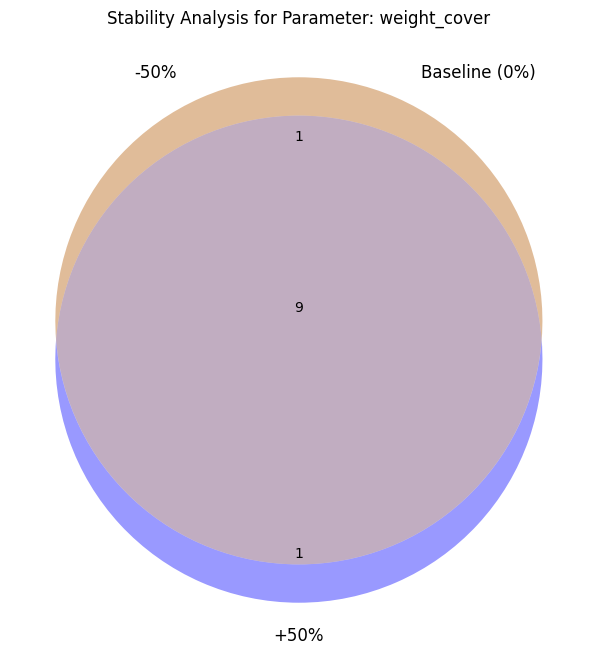

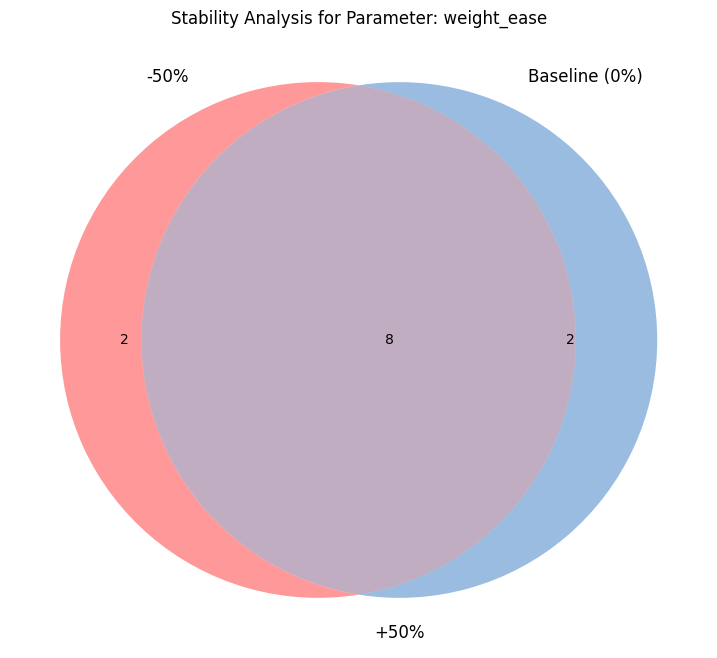

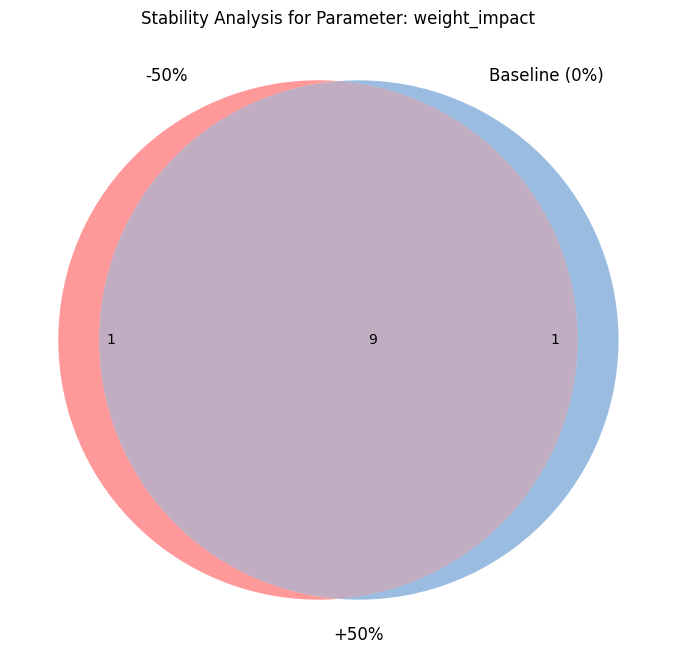

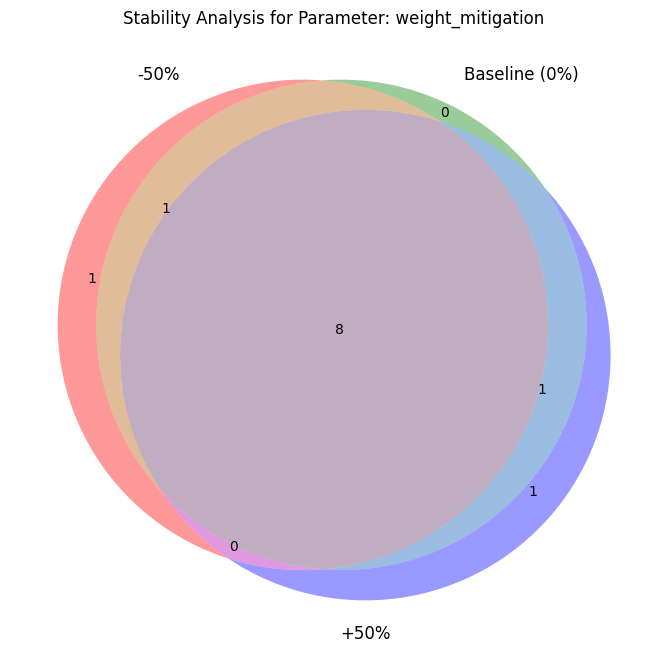

In [16]:
def plot_venn_diagram_for_param(param):
    """
    Creates a Venn diagram comparing the indicator selection across 
    three variations (-50%, 0%, +50%) for a given parameter.
    """
    subset = stability_df[stability_df['Parameter'] == param]

    # Extract sets for three variations
    set_minus_50 = set(subset[subset['Variation (%)'] == -50]['Selected Indicators'].iloc[0])
    set_0 = set(subset[subset['Variation (%)'] == 0]['Selected Indicators'].iloc[0])
    set_plus_50 = set(subset[subset['Variation (%)'] == 50]['Selected Indicators'].iloc[0])

    # Plot the Venn Diagram
    plt.figure(figsize=(10, 8))
    venn3([set_minus_50, set_0, set_plus_50], 
          set_labels=('-50%', 'Baseline (0%)', '+50%'))

    plt.title(f'Stability Analysis for Parameter: {param}')
    #plt.show()
    save_plot(plt.gcf(),"stability_analysis_"+param)

# Plot Venn diagrams for all tested parameters
for param in parameters_to_test:
    plot_venn_diagram_for_param(param)
